# Getting started

Thanks for checking out Salty! 

The purpose of Salty is to extend some of the machine learning ecosystem to ionic liquid (IL) data from [ILThermo](http://ilthermo.boulder.nist.gov/).

## Obtaining Smiles Strings

Salty operates using the simplified molecular-input line-entry system ([SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)). One of the core methods of Salty is the `check_name()` function that converts [IUPAC](https://iupac.org/) naming to Smiles:

In [4]:
import salty
smiles = salty.check_name("1-butyl-3-methylimidazolium")
print(smiles)

CCCCn1cc[n+](c1)C


once we have a smiles representation of a molecule, we can convert it into a molecular object with RDKit:

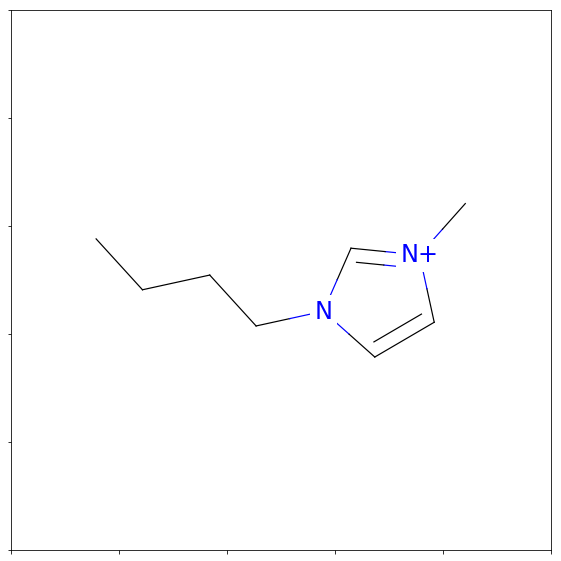

In [5]:
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import Draw
fig = Draw.MolToMPL(Chem.MolFromSmiles(smiles),figsize=(5,5))

Once we have a molecular object, we can generate many kinds of bitvector representations or *fingerprints*.

Fingerprints can be used as descriptors in machine learning models, uncertainty estimators in structure search algorithms, or, as shown below, to simply compare two molecular structures:

In [6]:
ms = [Chem.MolFromSmiles("OC(=O)C(N)Cc1ccc(O)cc1"), Chem.MolFromSmiles(smiles)]
fig=Draw.MolsToGridImage(ms[:],molsPerRow=2,subImgSize=(400,200))
fig.save('compare.png')
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

radius = 2

fpatom = [Pairs.GetAtomPairFingerprintAsBitVect(x) for x in ms]
print("atom pair score: {:8.4f}".format(DataStructs.TanimotoSimilarity(fpatom[0], fpatom[1])))
fpmorg = [AllChem.GetMorganFingerprint(ms[0],radius,useFeatures=True),
          AllChem.GetMorganFingerprint(ms[1],radius,useFeatures=True)]
fptopo = [FingerprintMols.FingerprintMol(x) for x in ms]
print("morgan score: {:11.4f}".format(DataStructs.TanimotoSimilarity(fpmorg[0], fpmorg[1])))
print("topological score: {:3.4f}".format(DataStructs.TanimotoSimilarity(fptopo[0], fptopo[1])))

atom pair score:   0.0513
morgan score:      0.0862
topological score: 0.3991


![](compare.png)

`check_name` is based on a curated data file of known cations and anions

In [7]:
print("Cations in database: {}".format(len(salty.load_data("cationInfo.csv"))))
print("Anions in database:  {}".format(len(salty.load_data("anionInfo.csv"))))

Cations in database: 316
Anions in database:  125


## A Few Useful Datafiles

Salty contains some csv datafiles taken directly from ILThermo: heat capacity (constant pressure), density, and viscosity data for pure ILs. The `aggregate_data` function can be used to quickly manipulate these datafiles and append 2D features.

In [8]:
rawdata = salty.load_data("cpt.csv")
rawdata.columns

Index(['Heat capacity at constant pressure per unit volume, J/K/m<SUP>3</SUP>',
       'Heat capacity at constant pressure, J/K/mol',
       'Heat capacity at constant pressure<SUP>*</SUP>, J/K/mol',
       'Pressure, kPa', 'Temperature, K', 'salt_name'],
      dtype='object')

In [9]:
devmodel = salty.aggregate_data(['cpt', 'density']) # other option is viscosity

`aggregate_data` returns a devmodel object that contains a pandas dataframe of the raw data and a data summary:

In [10]:
devmodel.Data_summary

,0
Unique salts,109
Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCCCCCCn1cc[n+]..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Total datapoints,7834
density,847.5 - 1557.1
cpt,207.47 - 1764.0
Temperature range (K),100.0 - 60000.0
Pressure range (kPa),273.15 - 463.15


and has scaled and centered 2D features from [rdkit](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors):

In [11]:
devmodel.Data.columns

Index(['steiger-anion', 'Marsili Partial Charges-anion', 'BalabanJ-anion',
       'BertzCT-anion', 'Ipc-anion', 'HallKierAlpha-anion', 'Kappa1-anion',
       'Kappa2-anion', 'Kappa3-anion', 'Chi0-anion',
       ...
       'VSA_EState10-cation', 'Topliss fragments-cation', 'Temperature, K',
       'Pressure, kPa', 'Heat capacity at constant pressure, J/K/mol',
       'Specific density, kg/m<SUP>3</SUP>', 'name-anion', 'smiles-anion',
       'name-cation', 'smiles-cation'],
      dtype='object', length=196)

The purpose of the data summary is to provide historical information when ML models are ported over into [GAINS](https://wesleybeckner.github.io/gains/). Once we have a devmodel the underlying data can be interrogated:

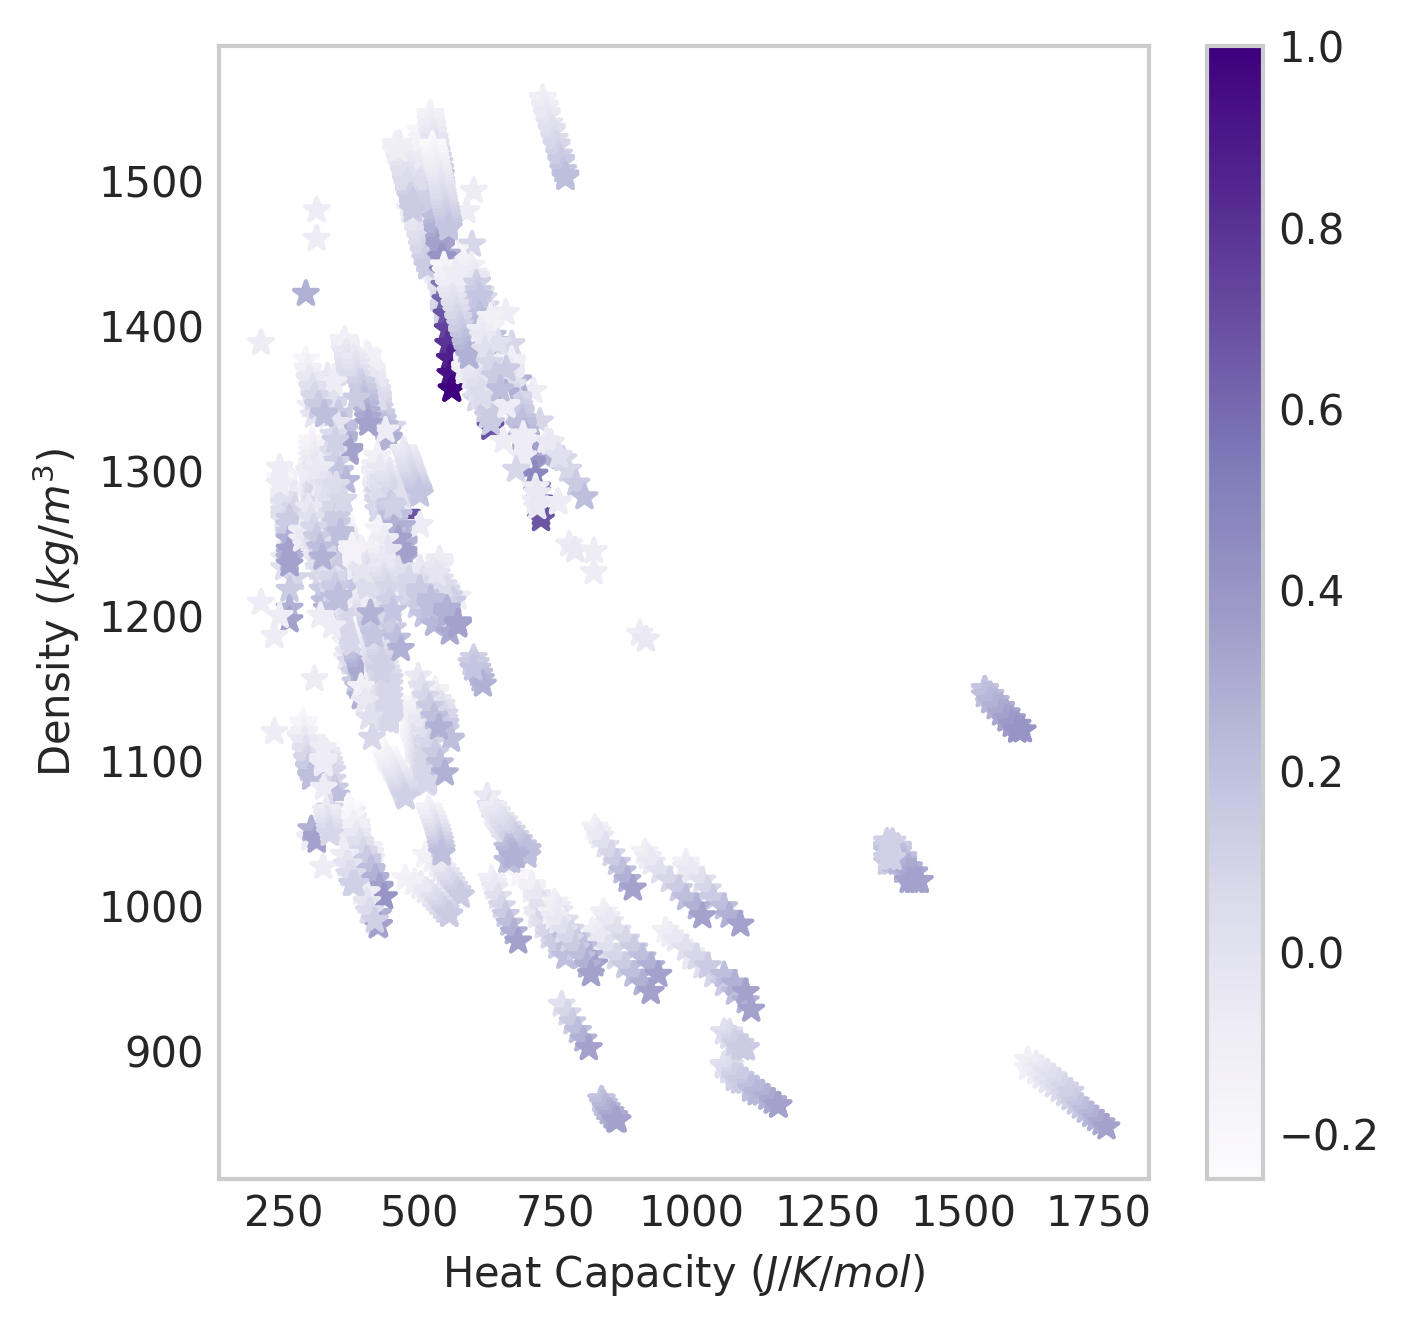

In [12]:
import matplotlib.pyplot as plt
import numpy as np
df = devmodel.Data
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    scat = ax.scatter(np.exp(df["Heat capacity at constant pressure, J/K/mol"]), np.exp(
        df["Specific density, kg/m<SUP>3</SUP>"]),
        marker="*", c=df["Temperature, K"]/max(df["Temperature, K"]), cmap="Purples")
    plt.colorbar(scat)
    ax.grid()
    ax.set_ylabel("Density $(kg/m^3)$")
    ax.set_xlabel("Heat Capacity $(J/K/mol)$")

## Build Models with Scikit-Learn

Salty's `devmodel_to_array` function automatically detects the number of targets in the devmodel and creates train/test arrays accordingly:

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
model = MLPRegressor(activation='relu', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
multi_model = MultiOutputRegressor(model)
X_train, Y_train, X_test, Y_test = salty.devmodel_to_array\
                                   (devmodel, train_fraction=0.8)
multi_model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=MLPRegressor(activation='relu', alpha=0.92078, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000000.0, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False),
           n_jobs=1)

We can then see how the model is performing with matplotlib:

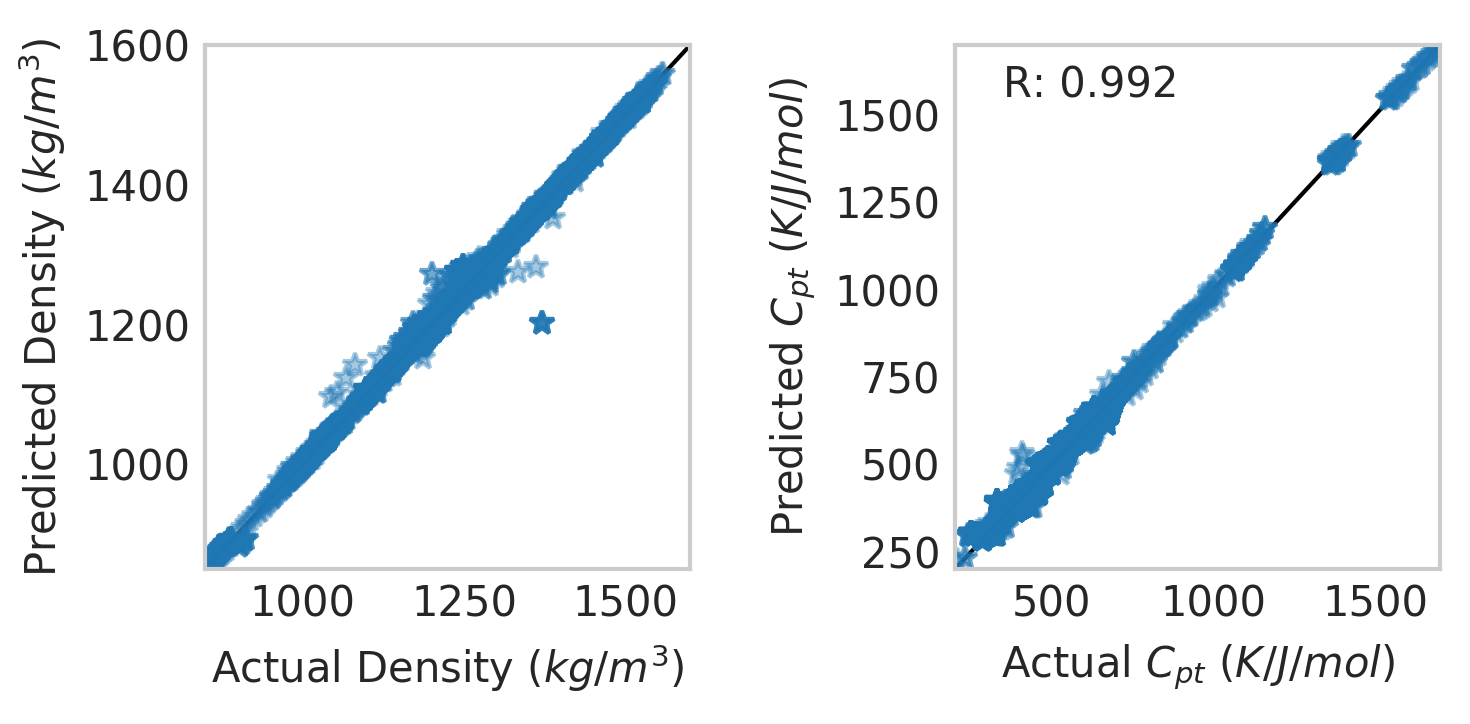

In [24]:
X=X_train
Y=Y_train
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,2.5), dpi=300)
    ax=fig.add_subplot(122)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,0],np.exp(multi_model.predict(X))[:,0],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("Actual $C_{pt}$ $(K/J/mol)$")
    ax.text(0.1,.9,"R: {0:5.3f}".format(multi_model.score(X,Y)), transform = ax.transAxes)
    plt.xlim(200,1700)
    plt.ylim(200,1700)
    ax.grid()
    ax=fig.add_subplot(121)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,1],np.exp(multi_model.predict(X))[:,1],\
            marker="*",linestyle="",alpha=0.4)
    
    ax.set_ylabel("Predicted Density $(kg/m^3)$")
    ax.set_xlabel("Actual Density $(kg/m^3)$")
    plt.xlim(850,1600)
    plt.ylim(850,1600)
    ax.grid()
    plt.tight_layout()

## Build Models with Keras

The above sklearn model has a very simple architecture (1 hidden layer with 75 nodes) we can recreate this in Keras:

In [17]:
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam

X_train, Y_train, X_test, Y_test = salty.devmodel_to_array\
    (devmodel, train_fraction=0.8)
model = Sequential()
model.add(Dense(75, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=['mse'])

In [18]:
model.fit(X_train,Y_train,epochs=1000,verbose=False)

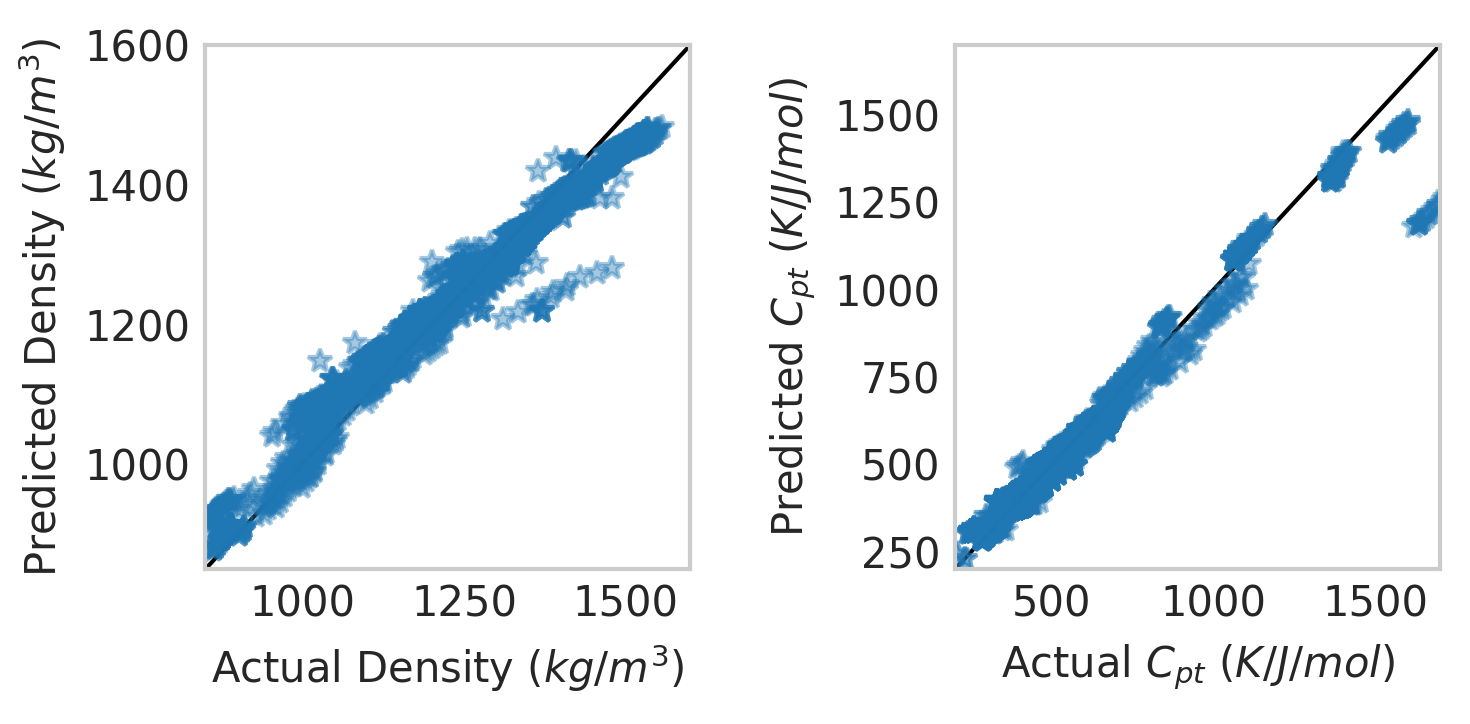

In [19]:
X=X_train
Y=Y_train
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,2.5), dpi=300)
    ax=fig.add_subplot(122)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,0],np.exp(model.predict(X))[:,0],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("Actual $C_{pt}$ $(K/J/mol)$")
    plt.xlim(200,1700)
    plt.ylim(200,1700)
    ax.grid()
    ax=fig.add_subplot(121)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,1],np.exp(model.predict(X))[:,1],\
            marker="*",linestyle="",alpha=0.4)
    
    ax.set_ylabel("Predicted Density $(kg/m^3)$")
    ax.set_xlabel("Actual Density $(kg/m^3)$")
    plt.xlim(850,1600)
    plt.ylim(850,1600)
    ax.grid()
    plt.tight_layout()

# Save Models for GAINS

In [50]:
model.save("_static/cpt_density_qspr.h5")
devmodel.Data_summary.to_csv("_static/cpt_density_summ.csv")
devmodel.Coef_data.to_csv("_static/cpt_density_desc.csv", index=False)

These are all the basic Salty functions for now!